<a href="https://colab.research.google.com/github/Khurramcoder/FSF-mathematics-python-code-archive/blob/master/newton_raphson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The aim of this notebook is to apply the Newton-Raphson solver to couple partial differential equations. The Newton-Raphson method is one of the techniques used for root finding (should the function admit one or several). The method is rather straight forward. For a given function $f(x)$, Taylor expand to the first order around an inital guess of where the root is ($x_{n}$):

$f(x) = f(x_{n}) + (x - x_{n})df(x_{n})$

At the root $x_{0}$:

$f(x_{0}) = f(x_{n}) + (x_{0} - x_{n})df(x_{n}) = 0$

Rearranging for $x_{0}$:

$x_{0} = x_{n} - f(x_{n})/df(x_{n})$

The newly calculated root $x_{0}$ replaces the original guess $x_{n}$ and the process is repeated iteratively until the ratio $\frac{f(x_{n})}{df(x_{n})}$ vanishes, or is below a certain threshold. The proper explicit differentiation would result in the following recursion:

$x_{i+1} = x_{i} - f(x_{i})/df(x_{i})$

Applying the to coupled differential equations is quite straight forward. The recursion relation for coupled functions is:

$\sum \limits_{j=1}^{n} \frac{\partial f_{i}}{\partial x_{j}}\delta x_{j} = -f_{i}(x)$

Where 'i' is the equation number. Hopefully the example will make things easier.

Consider the following coupled 1st order differential equations:

$\begin{cases}
\frac{d y_{1}}{dx} = \alpha y_{1} + \beta y_{2}\\
\frac{d y_{2}}{dx} = \gamma y_{1} + \sigma y_{2}
\end{cases}$

Where $\alpha$, $\beta$, $\gamma$, and $\sigma$ are constants. For the method to work, we must perform implicit discritization

$\begin{cases}
\frac{y_{1}(i+1) - y_{1}(i)}{\Delta t} = \alpha y_{1}(i+1) + \beta y_{2}(i+1)\\
\frac{y_{2}(i+1) - y_{2}(i)}{\Delta t} = \gamma y_{1}(i+1) + \sigma y_{2}(i+1)
\end{cases}$

Re-arranging and factorizing:

$\begin{cases}
y_{1}(i+1)[1 - \alpha\Delta t] - \beta\Delta t y_{2}(i+1) - y_{1}(i) = f_{1}\\
y_{2}(i+1)[1 - \sigma\Delta t] - \gamma\Delta t y_{1}(i+1) - y_{2}(i) = f_{2}
\end{cases}$

Taking derivatives with respect to the variables that are at index (i+1) we get:

$\begin{cases}
[1 - \alpha\Delta t]\delta y_{1} - \beta\Delta t\delta y_{2} = -f_{1}\\
[1 - \sigma\Delta t]\delta y_{2} - \gamma\Delta t y_{1} = -f_{2}
\end{cases}$

Since we have two equations in two unknows, being the $\delta$ terms. We can solve the following matrix equation iteratively until the maximum $\delta$ is below a specified tolerance.


$\begin{bmatrix}
[1 - \alpha\Delta t] & - \beta\Delta t\\
[1 - \sigma\Delta t] & - \gamma\Delta t
\end{bmatrix}*\begin{bmatrix}
\delta y_{1}\\
\delta y_{2}
\end{bmatrix} = \begin{bmatrix}
-f_{1}\\
-f_{2}
\end{bmatrix}$

The following python script will solve the above example with
$\begin{cases}
\alpha = -1\\
\beta = 100\\
\gamma = 1\\
\sigma = -100
\end{cases}$

and initial values of

$\begin{cases}
y_{1}(0) = 0\\
y_{2}(0) = 1
\end{cases}$

In [1]:
#Here we quietly check and install missing python libraries
import sys, subprocess,pkg_resources
required = {'numpy','matplotlib'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    subprocess.check_call([sys.executable,'-m','pip','install','--quiet',*missing])

#importing the required libraries to perform the calculation
import numpy as np
import matplotlib.pyplot as plt

<ipython-input-1-ab8fea2abbce>:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import sys, subprocess,pkg_resources


In [2]:
#the defined functions f1 and f2
def f1_ex(dt,y1,y1_dt,y2_dt,alpha,beta):
    return y1_dt*(1 - alpha*dt) - beta*dt*y2_dt -y1
def f2_ex(dt,y2,y1_dt,y2_dt,gamma,sigma):
    return y2_dt*(1 - sigma*dt) - gamma*dt*y1_dt - y2

#Newton raphson solver
def newt_raph_solve(n_tot,alpha,beta,gamma,sigma,dt,y1,y2,y1_dt,y2_dt,y11,y22,t,tol,A):

    for i in range (1,n_tot):
        #x is defined before the loop to guarantee that the calculation is done at least once
        x = np.ones(2)
        while (abs(max(x)) > tol):
            b = np.array([-f1_ex(dt,y1,y1_dt,y2_dt,alpha,beta),
            -f2_ex(dt,y2,y1_dt,y2_dt,gamma,sigma)])
            x = np.linalg.solve(A,b)
            y1_dt += x[0]
            y2_dt += x[1]

        #update the new values
        y1 = y1_dt
        y2 = y2_dt

        #reset the guess to the newly calculated values
        y1_dt = y1
        y2_dt = y2

        #update the returned vectors
        t = np.append(t,i*dt)
        y11 = np.append(y11,y1)
        y22 = np.append(y22,y2)

    return y11,y22,t


In the following cell, we define the initial conditions, parameters, time step and setup the arrays to be used during the calculation

In [3]:
#initial values at t = 0
y1 = 0
y2 = 1
alpha = -1
beta = 100
gamma = 1
sigma = -100

#A good guess for the algorithm to work is the initial value
y1_dt = y1
y2_dt = y2

#time step
dt = 0.05

#total number of time steps
n_tot = 200

#tolerance
tol = 1e-6

#arrays for graphing (will be appended during calculation)
t = 0
y11 = y1
y22 = y2

Since the matix doesn't evolve with time, it is more convenient to define it here

In [4]:
A = np.array([[1 - alpha*dt, -beta*dt],[1 - sigma*dt, -gamma*dt]])

Here we call the pre defined solver. It is fed the matrix, the parameters, and the vectors, and returns the fully appended vectors after convergence for the last time step

In [5]:
y11,y22,t = newt_raph_solve(n_tot,alpha,beta,gamma,sigma,dt,y1,y2,y1_dt,y2_dt,y11,y22,t,tol,A)

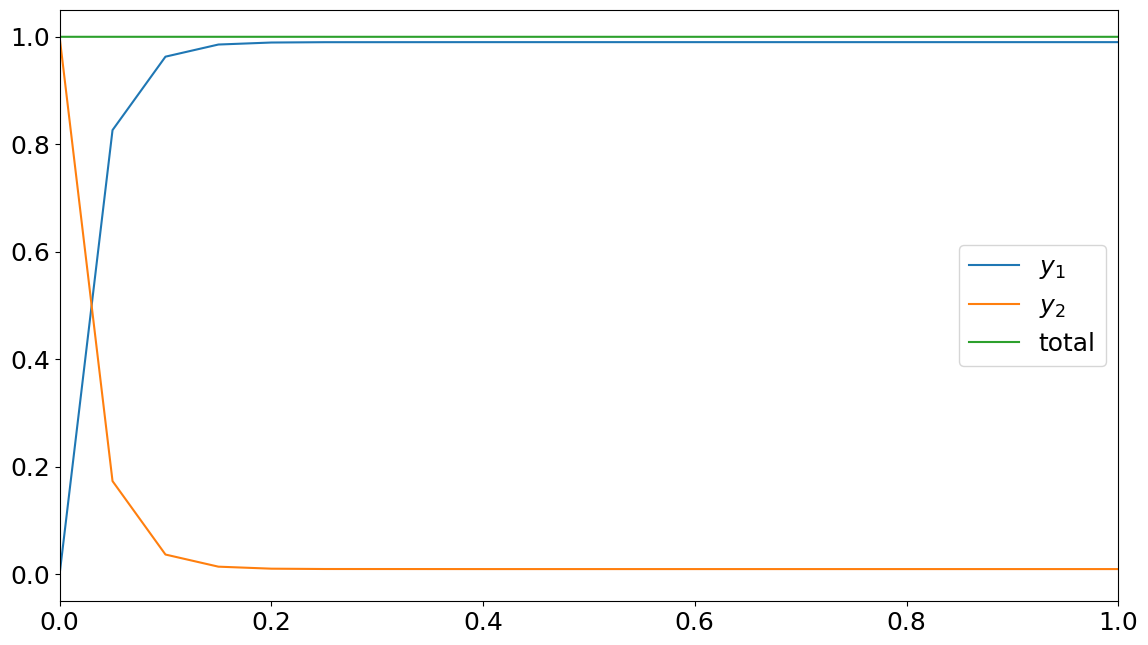

In [6]:
plt.figure(figsize = [13.66,7.68])
plt.rcParams['font.size'] = 18
plt.plot(t,y11,label = r'$y_{1}$')
plt.plot(t,y22,label = r'$y_{2}$')
#to prove that the sum total is conserved, it is being graphed as well
plt.plot(t,y11+y22,label = 'total')
plt.legend()
plt.xlim([0,1])
plt.show()

You can ofcourse go back and change $\alpha$, $\beta$, $\gamma$, $\sigma$, and initial conditions to see how it changes.

Now let's apply the same technique to a more astrophysical problem. For example, consider a galaxy forming by all of it's mass sitting in its halo condensing into the galactic plane, with a simple star formation rate.

The system of coupled differential equations that governs the evolution of mass distribution as a function of time is as follows

$\begin{cases}
\frac{d M_{sf}}{dt} = \frac{M_{dg}}{\tau_{s}}\\
\frac{d M_{dg}}{dt} = \frac{M_{hg}}{\tau_{infall}} - \frac{M_{dg}}{\tau_{s}}\\
\frac{dM_{hg}}{dt}  = - \frac{M_{hg}}{\tau_{infall}}
\end{cases}$

Where $M_{dg}$, $M_{hg}$, and $M_{sf}$ are the Disk gas, halo gas, and star formation respectively. $\tau_{s}$ and $\tau_{infall}$ are the star formation gas infall time scales respectively. It is quite a simple model, but it helps visualize the process of mass evolution on a galactice scale.

The implicit discretization for the system is as follows

$\begin{cases}
M_{sf}(i+1) - \frac{\Delta t}{\tau_{s}}M_{dg}(i+1) - M_{sf}(i) = f_{1}\\
M_{dg}(i+1)[1 + \frac{\Delta t}{\tau_{s}}] - \frac{\Delta t}{\tau_{infall}}M_{hg}(i+1) - M_{dg}(i) = f_{2}\\
M_{hg}(i+1)[1 + \frac{\Delta t}{\tau_{infall}}] - M_{hg}(i) = f_{3}
\end{cases}$

Differentiating with respect to the variables at (i+1), we get:

$\begin{cases}
\delta_{sf} - \frac{\Delta t}{\tau_{s}}\delta_{dg} = -f_{1}\\
\delta_{dg}[1 + \frac{\Delta t}{\tau_{s}}] - \frac{\Delta t}{\tau_{infall}}\delta_{hg} = -f_{2}\\
\delta_{hg}[1 + \frac{\Delta t}{\tau_{infall}}] = -f_{3}
\end{cases}$

The matrix equation to be solved is

$\begin{bmatrix}
1 & -\frac{\Delta t}{\tau_{s}} & 0\\
0 & [1 + \frac{\Delta t}{\tau_{s}}] & -\frac{\Delta t}{\tau_{infall}}\\
0 & 0 & [1 + \frac{\Delta t}{\tau_{infall}}]
\end{bmatrix} * \begin{bmatrix}
\delta_{sf}\\
\delta_{dg}\\
\delta_{hg}\\
\end{bmatrix}=\begin{bmatrix}
-f_{1}\\
-f_{2}\\
-f_{3}
\end{bmatrix}$

In [7]:
#The following definitions are for astro example
def f1(m_sf_dt,m_dg_dt,m_sf,dt,t_sf):
    return m_sf_dt - (dt/t_sf)*m_dg_dt - m_sf

def f3(m_hg_dt,m_hg,dt,t_infall):
    return m_hg_dt*(1 + dt/t_infall) - m_hg

def f2(m_dg_dt,m_hg_dt,m_dg,dt,t_sf,t_infall):
    return m_dg_dt*(1+dt/t_sf) - (dt/t_infall)*m_hg_dt - m_dg

def newt_raph_solver(A,m_hg,m_dg,m_sf,m_hg_dt,m_dg_dt,m_sf_dt,t,dt,t_sf,t_infall,n_tot,tol):
    m_sf_1 = m_sf
    m_dg_1 = m_dg
    m_hg_1 = m_hg
    for i in range(1,n_tot):
        delta = np.ones(3)
        while np.max(abs(delta)) >= tol:
            b = np.array([-f1(m_sf_dt,m_dg_dt,m_sf,dt,t_sf),
            -f2(m_dg_dt,m_hg_dt,m_dg,dt,t_sf,t_infall),
            -f3(m_hg_dt,m_hg,dt,t_infall)])

            delta = np.linalg.solve(A,b)
            m_sf_dt += delta[0]
            m_dg_dt += delta[1]
            m_hg_dt += delta[2]
        #updating the values
        m_sf = m_sf_dt
        m_dg = m_dg_dt
        m_hg = m_hg_dt
        #appending the arrays
        m_sf_1 = np.append(m_sf_1,m_sf)
        m_dg_1 = np.append(m_dg_1,m_dg)
        m_hg_1 = np.append(m_hg_1,m_hg)
        t = np.append(t,i*dt)
        #resetting error array to ensure while condition is satisfied at least once

    return m_hg_1,m_dg_1,m_sf_1,t

Setting the initial values, vectors, and matrix

In [8]:
#parameters
t_infall = 1e+9
t_sf     = 1e+9
tol      = 1e-5
dt       = 1e+6 #years
n_tot    = 13800 #Here we assume the galaxy has had the age of the universe to evolve from start till "now"

#initial conditions and guess in solar masses, these will be appended after each converged step
m_hg  = 1e+11
m_dg  = 0
m_sf  = 0
#initial guesses
m_hg_dt = m_hg
m_dg_dt = m_dg
m_sf_dt = m_sf

t     = 0

#setting up the array since it will remain constant
A = np.array([[1 , -dt/t_sf,0],[0,1+dt/t_sf,-dt/t_infall],[0,0,1+dt/t_infall]])

Here we simply call the solver and graph the results

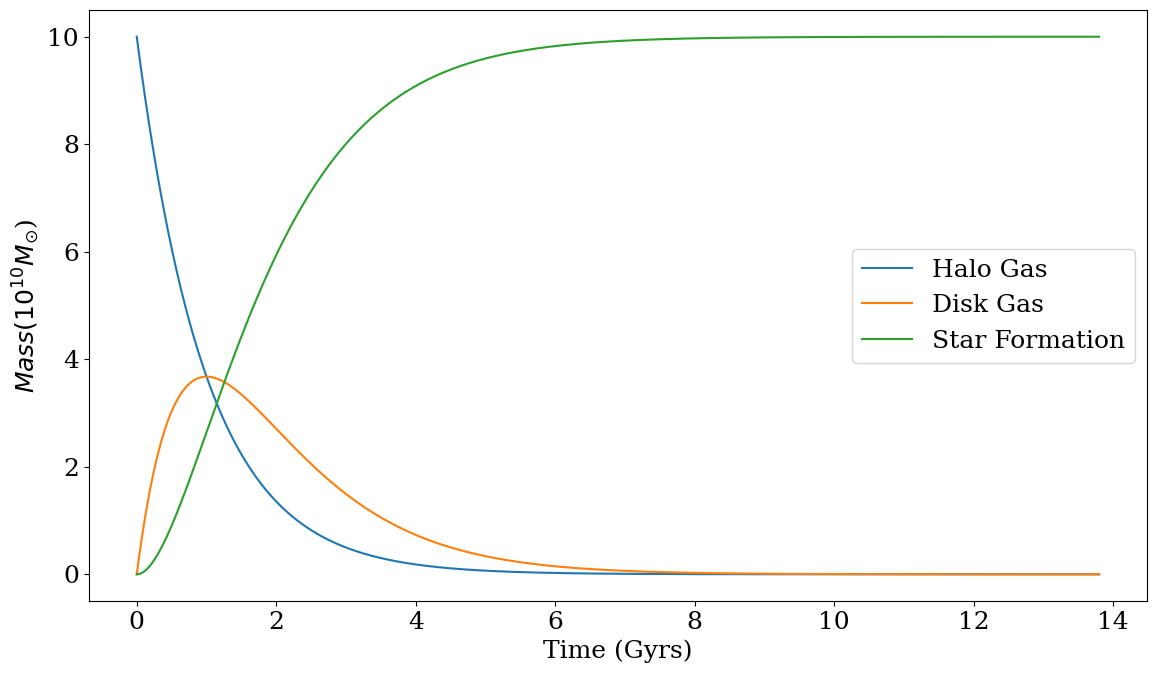

In [9]:
m_hg,m_dg,m_sf,t = newt_raph_solver(A,m_hg,m_dg,m_sf,m_hg_dt,m_dg_dt,m_sf_dt,t,dt,t_sf,t_infall,n_tot,tol)

# plotting options
plt.figure(figsize = [13.66,7.68])
plt.rc('font', family='serif')
plt.rcParams['font.size'] = 18

plt.plot(t/1e+9,m_hg/1e+10,label = 'Halo Gas')
plt.plot(t/1e+9,m_dg/1e+10,label = 'Disk Gas')
plt.plot(t/1e+9,m_sf/1e+10,label = 'Star Formation')

plt.xlabel('Time (Gyrs)')
plt.ylabel(r'$Mass (10^{10} M_{\odot}$)')
plt.legend()
plt.show()
